In [1]:
!git clone https://github.com/bearpelican/musicautobot.git

fatal: destination path 'musicautobot' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('musicautobot')

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
!apt install musescore fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install torch fastai music21 pebble fluidsynth midi2audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
musescore is already the newest version (2.1.0+dfsg3-3build1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [6]:
!pip install musicautobot

In [7]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.numpy_encode import stream2npenc_parts
from musicautobot.utils.setup_musescore import setup_musescore
setup_musescore()

In [8]:
from midi2audio import FluidSynth
from IPython.display import Audio

In [9]:
def play_wav(stream):
    out_midi = stream.write('midi')
    out_wav = str(Path(out_midi).with_suffix('.wav'))
    FluidSynth("font.sf2").midi_to_audio(out_midi, out_wav)
    return Audio(out_wav)

In [10]:

config = multitask_config();

midi_path =  Path('/content/drive/MyDrive/data/midi')

data_path = Path('/content/drive/MyDrive/data/numpy')
data_save_name = 'musicitem_data_save.pkl'

In [11]:

data = MusicDataBunch.empty(data_path)
vocab = data.vocab

In [12]:

pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MultitaskSmallKeyC.pth'
# pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MultitaskSmall.pth'
pretrained_path = data_path/'pretrained'/Path(pretrained_url).name
pretrained_path.parent.mkdir(parents=True, exist_ok=True)
download_url(pretrained_url, dest=pretrained_path)

In [13]:

learn = multitask_model_learner(data, pretrained_path=pretrained_path)


In [14]:

example_dir = midi_path/'examples/Bach'
midi_files = get_files(example_dir, recurse=True, extensions='.midi'); midi_files[:26]

[PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/kunst_der_fuge_01_(c)maclean.midi'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/bach_art_of_fugue_1080_1_(c)harfesoft.midi'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/bach_art_of_fugue_1080_2_(c)harfesoft.midi'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/kunst_der_fuge_11_(c)maclean.midi'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/kunst_der_fuge_10_(c)maclean.midi')]

In [15]:
file = midi_files[0]; file

PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/kunst_der_fuge_01_(c)maclean.midi')

In [16]:

item = MusicItem.from_file(file, data.vocab)

x = item.to_tensor()
x_pos = item.get_pos_tensor()

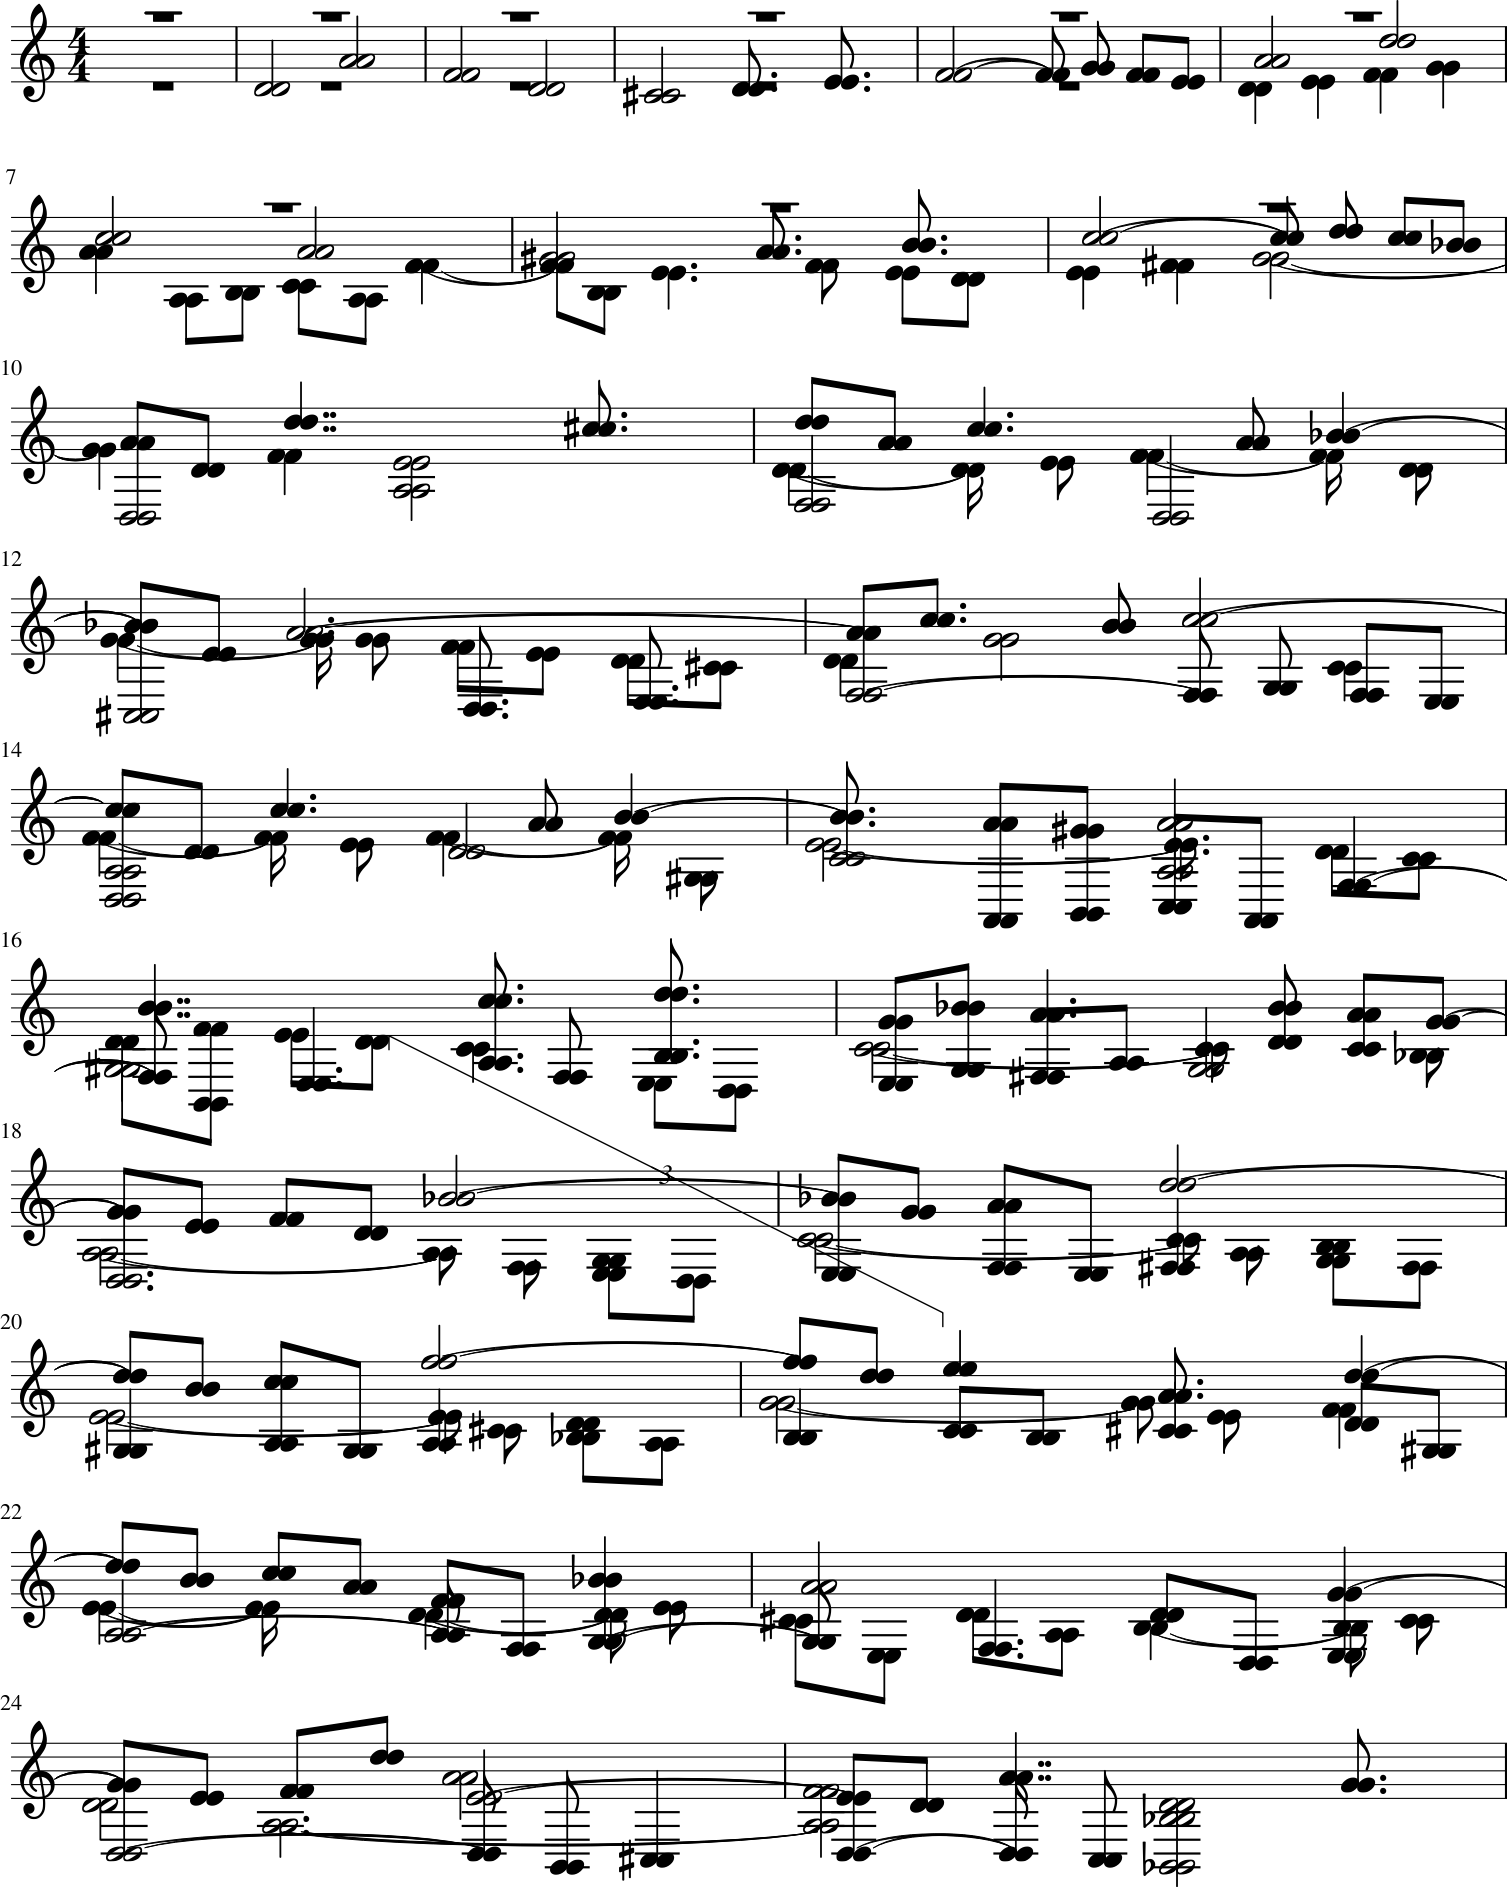

In [17]:
item.show()

In [18]:
# item.play()
#play_wav(item.stream)

1. NextWord/Autocomplete

In [19]:
seed_len = 200 
seed = item.trim_to_beat(seed_len)

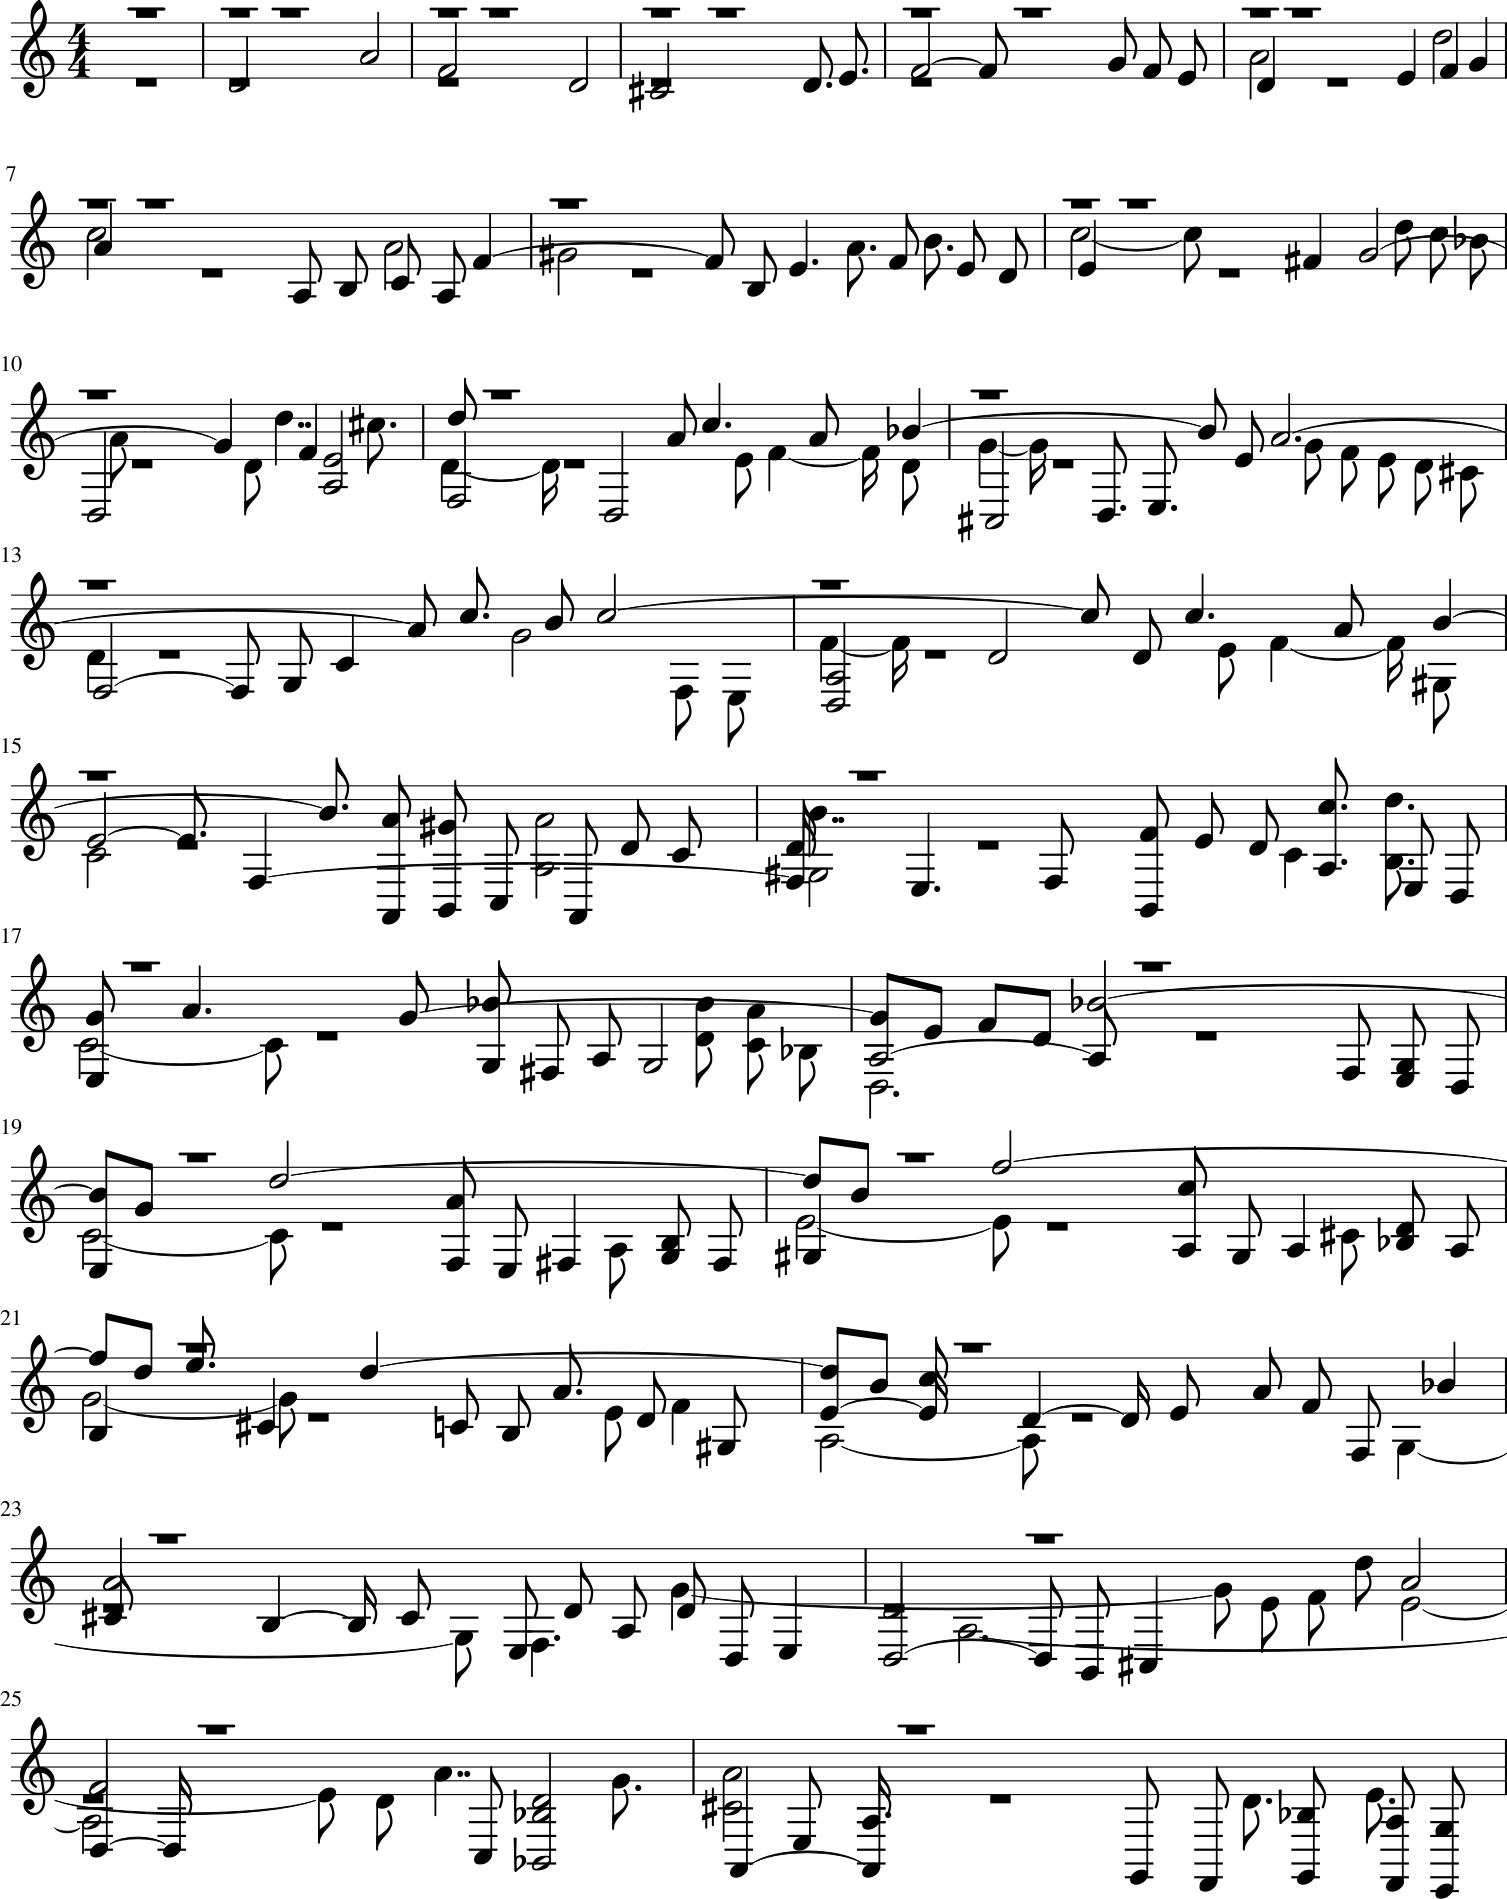

In [20]:
seed.show()

In [21]:
pred_nw, full = learn.predict_nw(seed, n_words=500)

/content/musicautobot/musicautobot/multitask_transformer/model.py:82: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bar_pos = pos // self.beat_len % self.max_bar_len
/content/musicautobot/musicautobot/multitask_transformer/learner.py:83: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if ((last_pos - start_pos) // 16) <= min_bars: logit

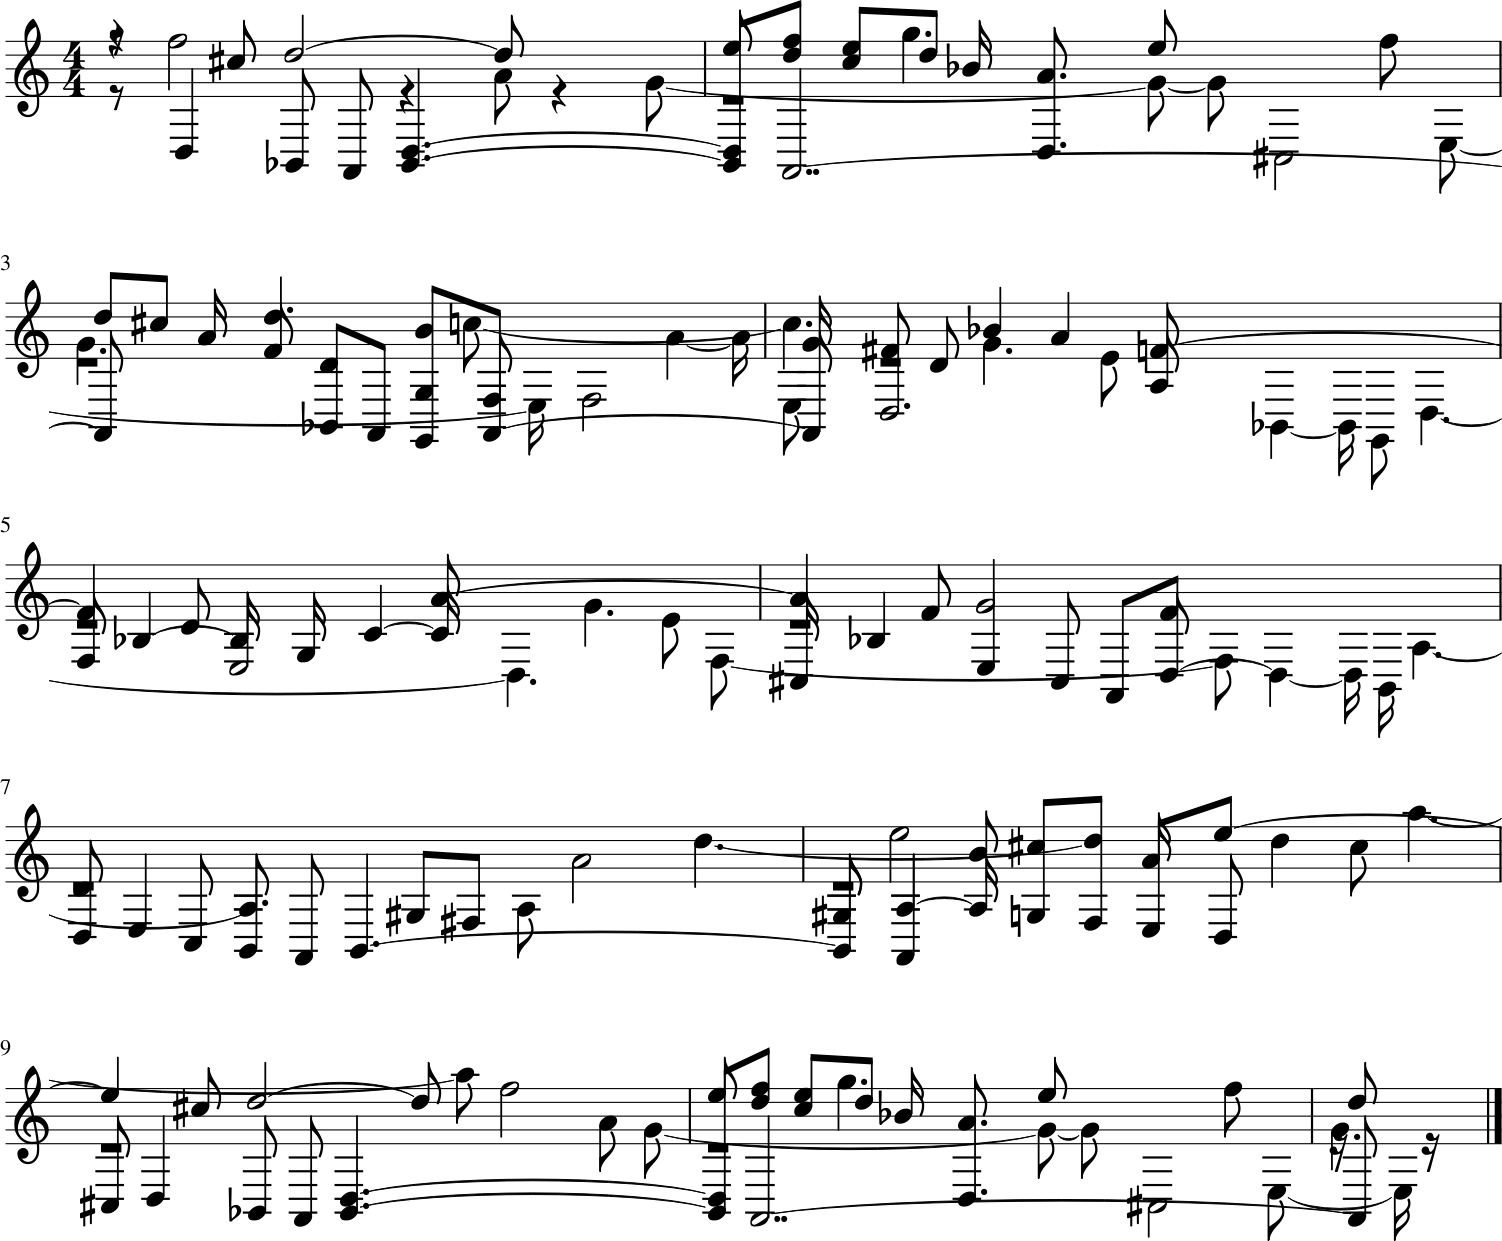

In [22]:
pred_nw.show()

In [23]:
play_wav(pred_nw.stream)

Output hidden; open in https://colab.research.google.com to view.

Add more randomness

/content/musicautobot/musicautobot/multitask_transformer/model.py:82: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bar_pos = pos // self.beat_len % self.max_bar_len
/content/musicautobot/musicautobot/multitask_transformer/learner.py:83: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if ((last_pos - start_pos) // 16) <= min_bars: logit

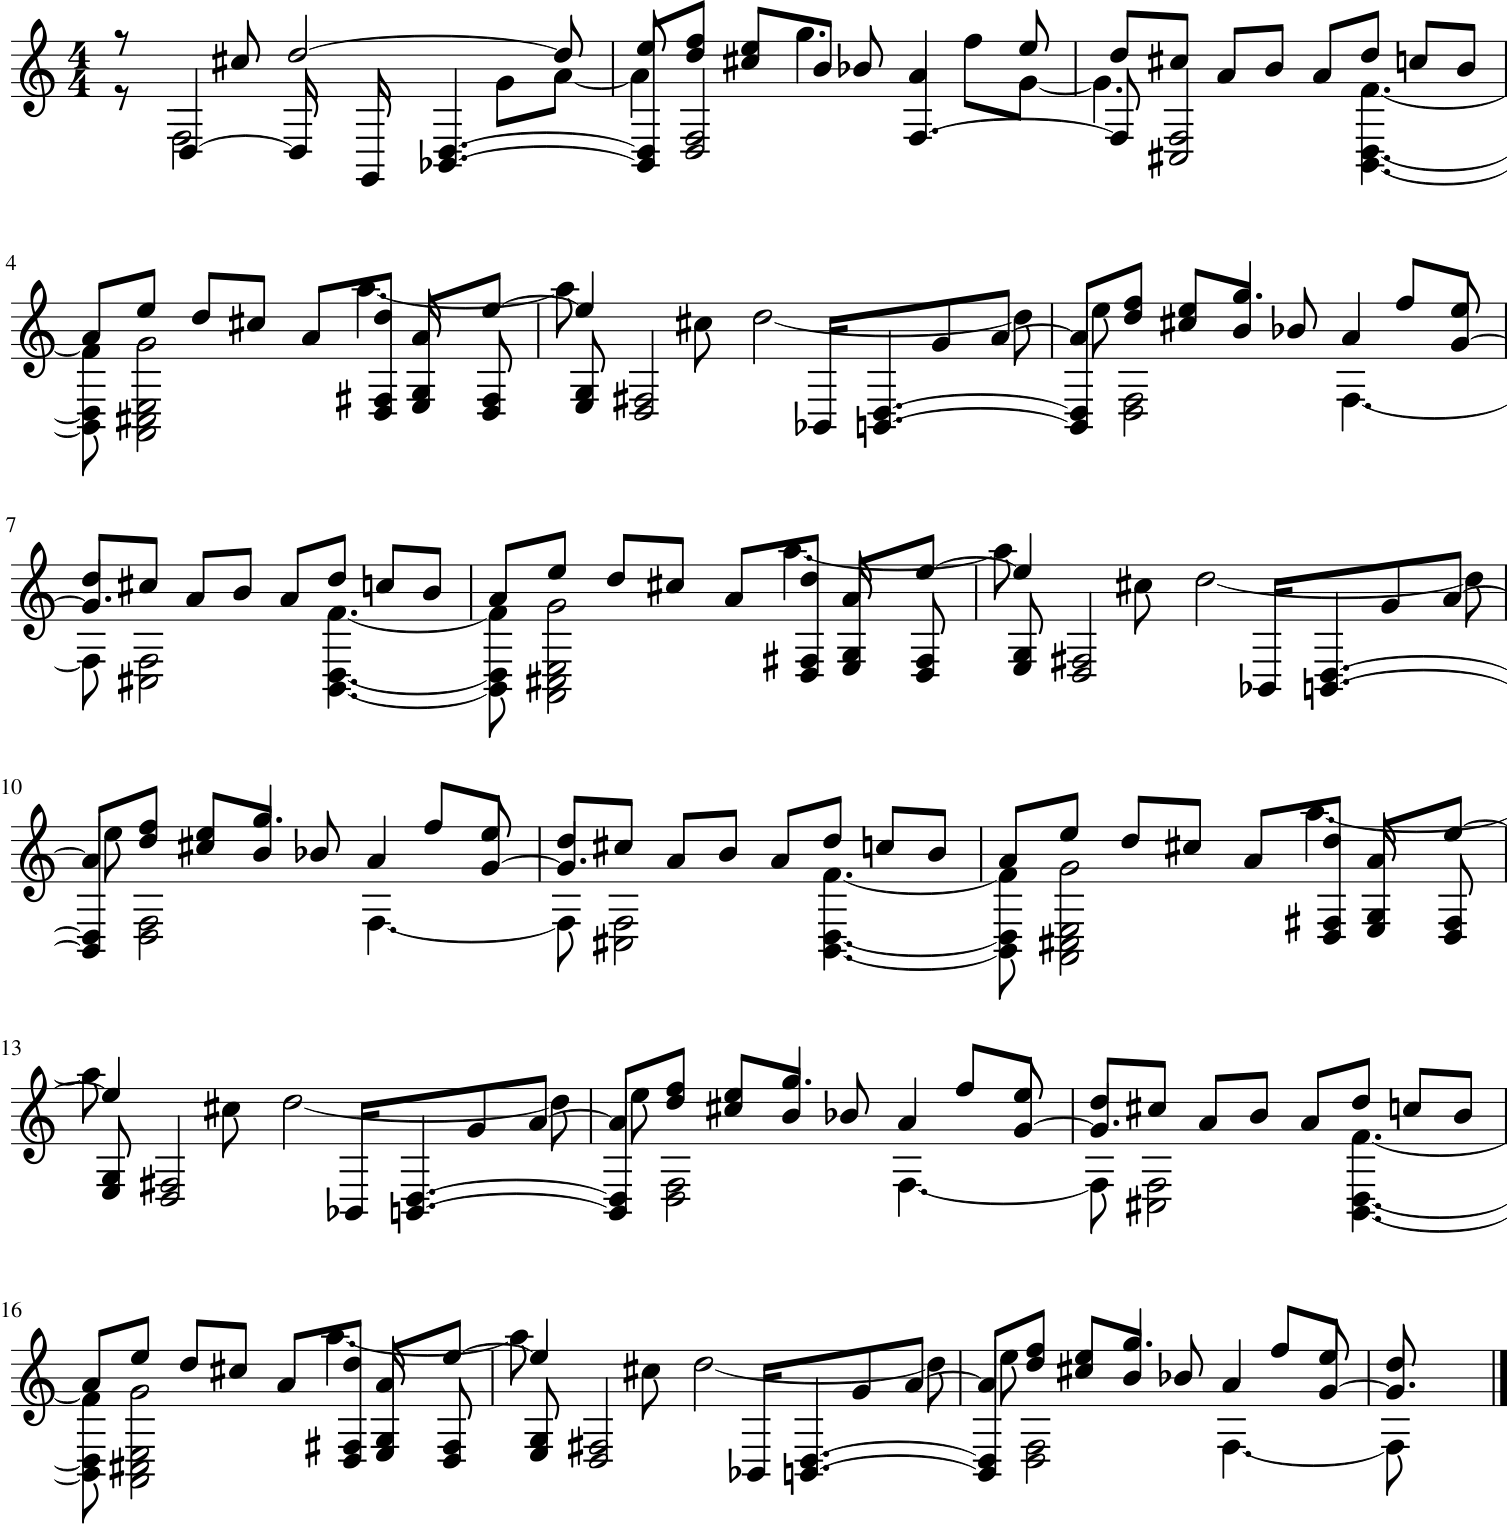

In [24]:
pitch_temp = 1.4 # randomness of melody
tempo_temp = 1.0 # randomness or rhythm
top_k = 40
pred_nw_rand, full = learn.predict_nw(seed, temperatures=(pitch_temp, tempo_temp), top_k=top_k, top_p=0.5, n_words=1000)
pred_nw_rand.show()

In [25]:
play_wav(pred_nw_rand.stream)

Output hidden; open in https://colab.research.google.com to view.